In [1]:
# Import dependencies
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

PyTorch version:  2.2.1
Torchvision version:  0.17.1


In [2]:
# Setup training data

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)




In [3]:
len(train_data), len(test_data)

(60000, 10000)

Image:  torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

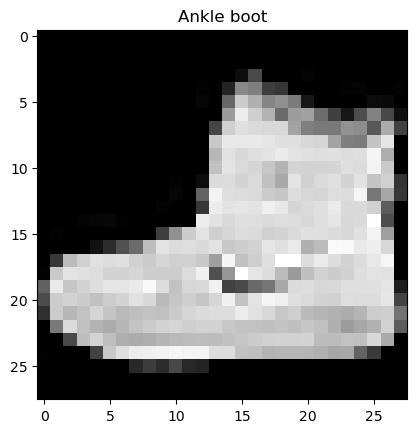

In [4]:
image, label = train_data[0]
print("Image: ", image.shape)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])

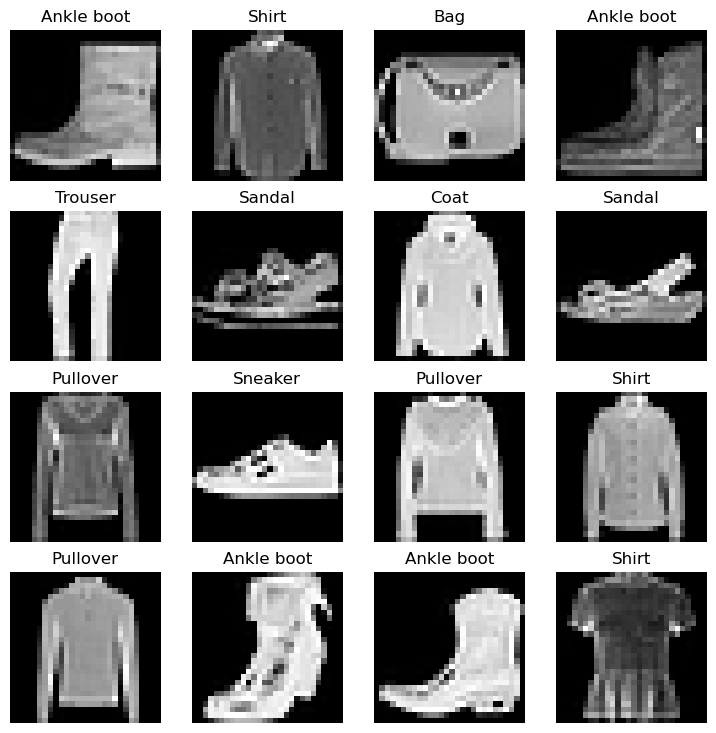

In [5]:
# Plot more images

torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, cols*rows+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis("off")
 

In [6]:
# Prepare data loaders

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"DataLoaders: {train_dataloader}, {test_dataloader}")
print(f"DataLoader Lengths: {len(train_dataloader)}, {len(test_dataloader)}")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x000001E6D9A23010>, <torch.utils.data.dataloader.DataLoader object at 0x000001E6D9AAF690>
DataLoader Lengths: 1875, 313


In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

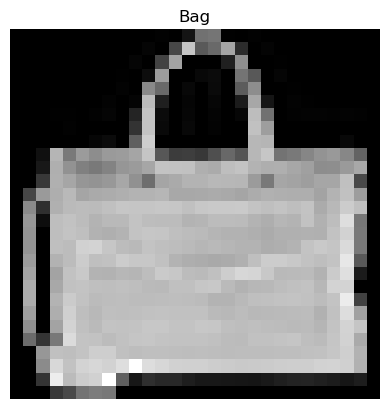

In [8]:
#torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.title(train_data.classes[label])
plt.axis("off")

plt.imshow(img.squeeze(), cmap="gray")

In [9]:
# Create flatten layer
flatten_model = nn.Flatten()

# Get a simple sample
x = train_features_batch[0]

# Flatten the image
output = flatten_model(x)

print(f"Original shape: {x.shape}")
print(f"Flattened shape: {output.shape}")


Original shape: torch.Size([1, 28, 28])
Flattened shape: torch.Size([1, 784])


In [10]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)


        


In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=28*28, 
                              hidden_units=10, 
                              output_shape=len(train_data.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [12]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
    print ("Helper function already downloaded")
else:
    print ("Downloading helper function")
    url = "https://raw.githubusercontent.com/lewtun/dl-visuals/main/helper_function.py"
    r = requests.get(url)
    with open("helper_function.py", "wb") as f:
        f.write(r.content)



Helper function already downloaded


In [13]:
# Import accuracy function
from helper_functions import accuracy_fn

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)




In [14]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Training time on device {device}: {total_time:.2f} seconds")

In [15]:
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")

    ## Training
    train_loss = 0

    # Loop through batches
    for batch, (X,y) in enumerate(train_dataloader):
        # Put model in training mode
        model_0.train()

        # Forward pass
        y_pred = model_0(X.to(device))

        # Calculate loss
        loss = loss_fn(y_pred, y.to(device))
        train_loss += loss

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    # Calculate avg loss per batch
    train_loss /= len(train_dataloader)

    ## Testing

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            #Forward pass
            test_pred = model_0(X_test.to(device))

            # Calculate loss
            test_loss += loss_fn(test_pred, y_test.to(device))

            # Calculate accuracy
            test_acc += accuracy_fn(y_test.to(device), test_pred.argmax(dim=1))

        # Calculate avg loss and acc per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Epoch {epoch}, Training Loss: {train_loss:.2f}, Testing Loss: {test_loss:.2f}, Testing Accuracy: {test_acc:.2f}")

# Calculate training time
train_time_end_on_gpu = timer()

print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device=device)

c:\ProgramData\anaconda3\envs\PyTorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:04<00:09,  4.74s/it]

Epoch 0, Training Loss: 0.59, Testing Loss: 0.51, Testing Accuracy: 82.04
Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:09<00:04,  4.83s/it]

Epoch 1, Training Loss: 0.48, Testing Loss: 0.48, Testing Accuracy: 83.20
Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:14<00:00,  4.89s/it]

Epoch 2, Training Loss: 0.46, Testing Loss: 0.48, Testing Accuracy: 83.43
Training time on device cuda: 14.67 seconds


# Make predictions

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Evaluate model
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)

print(model_0_results)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}


### Create a model with linear and non-linear layers

In [17]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)



In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=28*28,
                                hidden_units=10,
                                output_shape=len(train_data.classes)).to(device)

next(model_1.parameters()).device


device(type='cuda', index=0)

In [19]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

from helper_functions import accuracy_fn

### Functionising training and evaluation loops

In [20]:
def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):


    ## Training
    train_loss, train_acc = 0, 0

    model.to(device)

    # Put model in training mode
    model.train()

    # Loop through batches
    for batch, (X,y) in enumerate(data_loader):

        # Put data on device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # 3. Zero gradients
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()
    
    # Calculate avg loss and acc
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Training Loss: {train_loss:.2f}, Training Accuracy: {train_acc:.2f}%")

In [21]:
def test_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):

     ## Testing

    # Instantiate loss and accuracy
    test_loss, test_acc = 0, 0

    model.to(device)

    # Put model in evaluation mode
    model.eval()

    # Start test loop
    with torch.inference_mode():
        for X_test, y_test in data_loader:

            # Put data on device
            X_test, y_test = X_test.to(device), y_test.to(device)

            #Forward pass
            test_pred = model(X_test)

            # Calculate loss
            test_loss += loss_fn(test_pred, y_test)

            # Calculate accuracy
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        # Calculate avg loss and acc per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Testing Loss: {test_loss:.2f}, Testing Accuracy: {test_acc:.2f}\n")

# Use training and testing functions

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")

    train_step(model= model_1,
                data_loader= train_dataloader,
                loss_fn= loss_fn,
                optimizer= optimizer,
                accuracy_fn= accuracy_fn,
                device= device)

    test_step(model= model_1,
                data_loader= test_dataloader,
                loss_fn= loss_fn,
                accuracy_fn= accuracy_fn,
                device= device)

# Calculate training time
train_time_end_on_gpu = timer()

print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device=device)



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Training Loss: 1.09, Training Accuracy: 61.34%


 33%|███▎      | 1/3 [00:05<00:11,  5.71s/it]

Testing Loss: 0.96, Testing Accuracy: 65.00

Epoch 1
-------------------------------
Training Loss: 0.78, Training Accuracy: 71.93%


 67%|██████▋   | 2/3 [00:11<00:05,  5.64s/it]

Testing Loss: 0.72, Testing Accuracy: 73.91

Epoch 2
-------------------------------
Training Loss: 0.67, Training Accuracy: 75.94%


100%|██████████| 3/3 [00:17<00:00,  5.68s/it]

Testing Loss: 0.69, Testing Accuracy: 75.02

Training time on device cuda: 17.04 seconds


In [23]:
# Get model_1 results dict
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

In [24]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Model 2: Convolutional Neural Network (CNN)

In [75]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [26]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                                hidden_units=10,
                                output_shape=len(train_data.classes)).to(device)

model_2
                                

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

from helper_functions import accuracy_fn

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")

    train_step(model= model_2,
                data_loader= train_dataloader,
                loss_fn= loss_fn,
                optimizer= optimizer,
                accuracy_fn= accuracy_fn,
                device= device)

    test_step(model= model_2,
                data_loader= test_dataloader,
                loss_fn= loss_fn,
                accuracy_fn= accuracy_fn,
                device= device)

# Calculate training time
train_time_end_on_gpu = timer()

print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Train loss: 0.59247 | Train accuracy: 78.59%


 33%|███▎      | 1/3 [00:06<00:13,  6.61s/it]

Test loss: 0.39214 | Test accuracy: 85.92%

Epoch 1
-------------------------------
Train loss: 0.35908 | Train accuracy: 87.05%


 67%|██████▋   | 2/3 [00:12<00:06,  6.43s/it]

Test loss: 0.34859 | Test accuracy: 87.25%

Epoch 2
-------------------------------
Train loss: 0.32131 | Train accuracy: 88.35%


100%|██████████| 3/3 [00:19<00:00,  6.39s/it]

Test loss: 0.32012 | Test accuracy: 88.50%

Training time on device cuda: 19.18 seconds


In [48]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
    
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, 0).to(device)

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob to cpu
            pred_probs.append(pred_prob.cpu())
    
    return torch.stack(pred_probs)



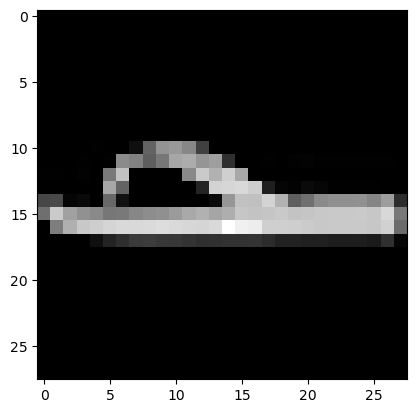

In [49]:
import random
#random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), 9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape
plt.imshow(test_samples[0].squeeze(), cmap='gray')

In [50]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                            data=test_samples,
                            device=device)
            
pred_classes = pred_probs.argmax(dim=1)

pred_classes, test_labels

(tensor([5, 6, 0, 1, 2, 2, 1, 4, 4]), [5, 2, 0, 1, 2, 2, 1, 4, 4])

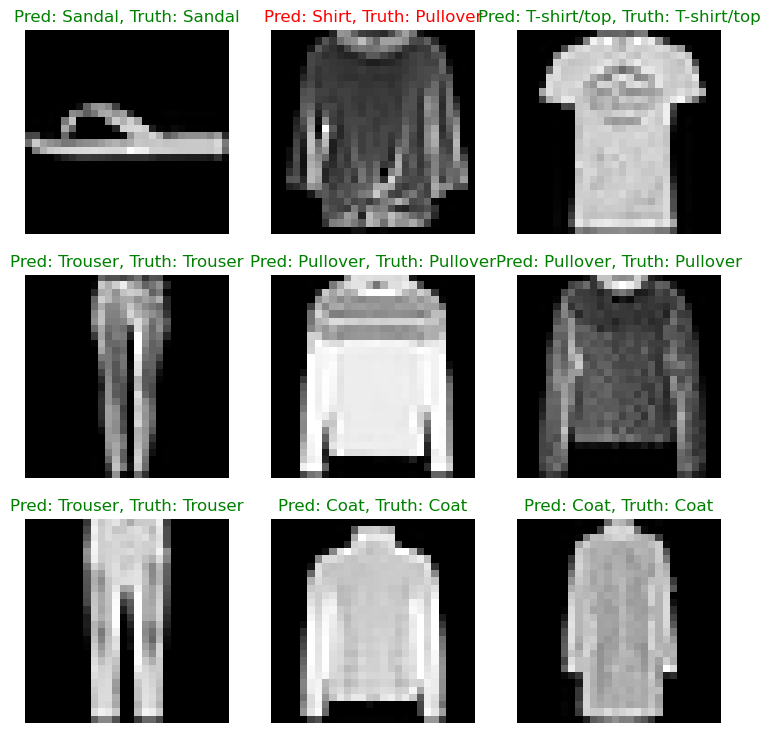

In [51]:
# Plott the predictions and labels

plt.figure(figsize=(9,9))
nrows, ncols = 3, 3

for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot sample
    plt.imshow(sample.squeeze(), cmap='gray')

    # Title with predicted and true label
    pred_label = train_data.classes[pred_classes[i]]

    # Get the truth label
    truth_label = train_data.classes[test_labels[i]]

    plt.title(f"Pred: {pred_label}, Truth: {truth_label}")

    if pred_label == truth_label:
        plt.title(f"Pred: {pred_label}, Truth: {truth_label}", color='green')
    else:
        plt.title(f"Pred: {pred_label}, Truth: {truth_label}", color='red')

    plt.axis('off')

In [56]:
import mlxtend

mlxtend.__version__

from tqdm.auto import tqdm

In [59]:
y_preds = []
model_2.to(device)
model_2.eval
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):

        X, y = X.to(device), y.to(device)

        y_logit = model_2(X)

        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

        y_preds.append(y_pred.cpu())


y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]
len(y_pred_tensor)

100%|██████████| 313/313 [00:00<00:00, 485.00it/s]


10000

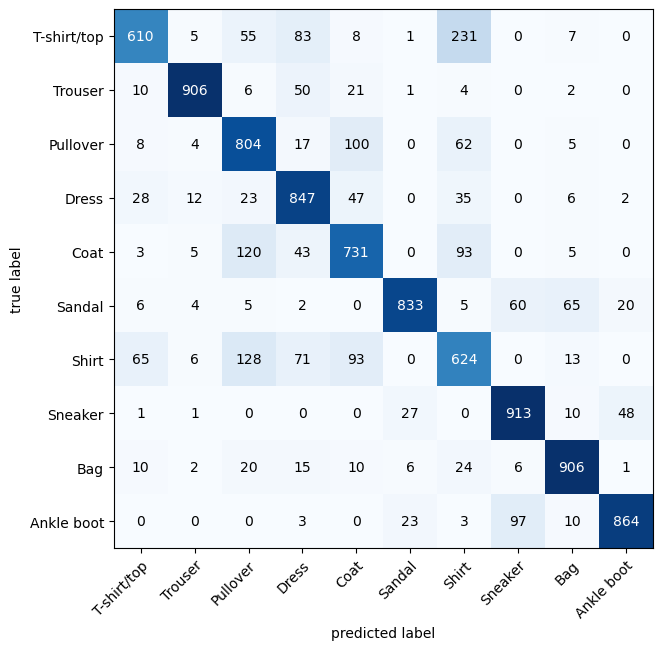

In [64]:
import torchmetrics

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(task='multiclass', num_classes=len(train_data.classes))
confmat_tensor = confmat(y_pred_tensor, test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=train_data.classes,
                                figsize=(10,7))

In [67]:
# Save and load best performing model

from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)

# create a model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model state dict at {MODEL_SAVE_PATH}")
torch.save(model_2.state_dict(), MODEL_SAVE_PATH)

Saving model state dict at models\03_pytorch_computer_vision_model_2.pth


In [68]:
# Create a new instance
torch.manual_seed(42)

# Create a new model instance
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(train_data.classes)).to(device)

# Load in the saved model state dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [77]:
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3201197385787964,
 'model_acc': 88.49840255591054}